# Chapter 3: Laboratory Analysis of Reservoir Fluids (QC & Smoothing)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
Real-world PVT laboratory reports are rarely perfect. They contain noise, typos, or measurement errors. In this notebook, we will:
1.  **Ingest Raw Lab Data:** Specifically from a Constant Composition Expansion (CCE) test.
2.  **Perform Quality Control (QC):** Use the **Y-Function** correlation to check data consistency below the bubble point.
3.  **Smooth the Data:** Mathematically correct the raw data to ensure it is physically consistent before using it in simulations.

## 1. The Theory: What is the Y-Function?

The Y-Function is a dimensionless group derived from the equation of state. It is used to smooth **Relative Volume ($V_{rel}$)** data obtained from CCE experiments below the bubble point pressure ($P_b$).

The definition is:
$$Y = \frac{P_{sat} - P}{P \cdot (V_{rel} - 1)}$$

**The Rule:**
When plotted against Pressure ($P$), the **Y-Function should form a straight line**.
* If the plot is jagged, the lab data is noisy.
* If a point falls far off the line, it is likely an error.

We can fit a straight line to the Y-function, and then work backward to calculate a "Smoothed" Relative Volume.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# --- 1. RAW LAB DATA (Simulation of a messy report) ---
# This data represents a Constant Composition Expansion (CCE) test
# Psat (Bubble Point) is 2500 psi.
# Note: Relative Volume (V_rel) = V_total / V_sat

data = {
    'Pressure': [2500, 2300, 2100, 1900, 1700, 1500, 1300, 1100, 900],
    'V_rel_meas': [1.000, 1.045, 1.100, 1.175, 1.258, 1.360, 1.485, 1.660, 1.950] 
}

# Create DataFrame
df = pd.DataFrame(data)

# Let's introduce a "Bad Data Point" manually to simulate a lab error
# At 1700 psi, let's make the volume artificially high (typo in report)
df.loc[df['Pressure'] == 1700, 'V_rel_meas'] = 1.290 

print("--- Raw Laboratory Data (with intentional error) ---")
print(df)

--- Raw Laboratory Data (with intentional error) ---
   Pressure  V_rel_meas
0      2500       1.000
1      2300       1.045
2      2100       1.100
3      1900       1.175
4      1700       1.290
5      1500       1.360
6      1300       1.485
7      1100       1.660
8       900       1.950


## 2. Calculating the Y-Function

We will now apply the formula to our dataframe. Note that we exclude the Bubble Point itself ($2500$ psi) because the denominator would be zero ($V_{rel} - 1 = 0$).

$$P_{sat} = 2500 \text{ psi}$$

--- Y-Function Calculated ---
   Pressure  V_rel_meas    Y_func
1      2300       1.045  1.932367
2      2100       1.100  1.904762
3      1900       1.175  1.804511
4      1700       1.290  1.622718
5      1500       1.360  1.851852
6      1300       1.485  1.903251
7      1100       1.660  1.928375
8       900       1.950  1.871345


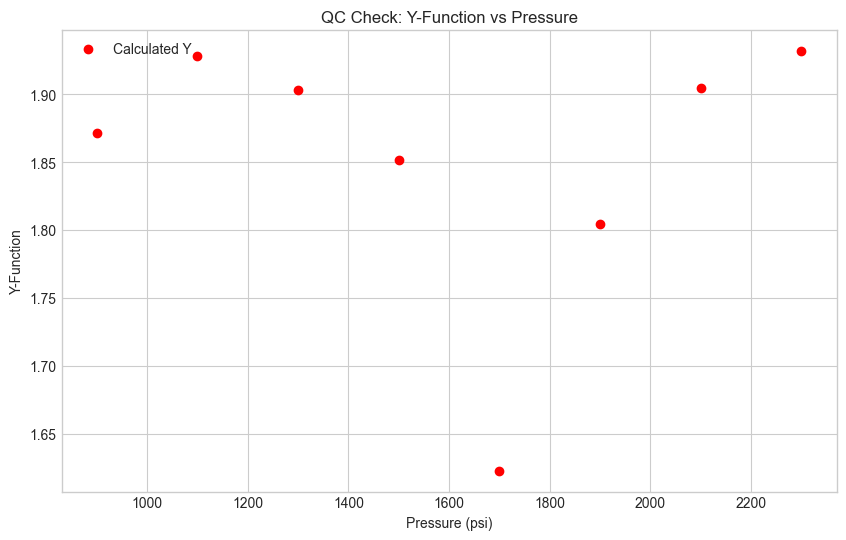

In [2]:
# Constants
Psat = 2500

# Filter data below bubble point for Y-function calculation
# (Y-function is undefined at Psat because V_rel = 1, division by zero)
df_sub = df[df['Pressure'] < Psat].copy()

# Calculate Y-Function
# Y = (Psat - P) / (P * (V_rel - 1))
df_sub['Y_func'] = (Psat - df_sub['Pressure']) / (df_sub['Pressure'] * (df_sub['V_rel_meas'] - 1))

print("--- Y-Function Calculated ---")
print(df_sub[['Pressure', 'V_rel_meas', 'Y_func']])

# Plotting the Y-Function to check for Linearity
plt.figure()
plt.scatter(df_sub['Pressure'], df_sub['Y_func'], color='red', label='Calculated Y')
plt.xlabel('Pressure (psi)')
plt.ylabel('Y-Function')
plt.title('QC Check: Y-Function vs Pressure')
plt.legend()
plt.grid(True)
plt.show()

## 3. Smoothing the Data (Linear Regression)

Observation from the plot above:
1.  Most points follow a trend.
2.  The point at **1700 psi** deviates significantly (our intentional error).

**The Correction Step:**
We will fit a **Linear Regression** line ($Y = mP + c$) to the Y-values. This "ideal line" represents the physics of the fluid better than the raw measurements.

In [3]:
# 1. Fit Linear Model
X = df_sub['Pressure'].values.reshape(-1, 1)
y = df_sub['Y_func'].values

model = LinearRegression()
model.fit(X, y)

# Get the straight line parameters
m = model.coef_[0]
c = model.intercept_
print(f"Fitted Line: Y = {m:.6f} * P + {c:.4f}")

# 2. Predict "Smoothed" Y values
df_sub['Y_smooth'] = model.predict(X)

# 3. Back-calculate "Smoothed" Relative Volume
# Rearranging the Y-Function formula:
# V_rel_smooth = 1 + [ (Psat - P) / (P * Y_smooth) ]

df_sub['V_rel_smooth'] = 1 + (Psat - df_sub['Pressure']) / (df_sub['Pressure'] * df_sub['Y_smooth'])

# Add the Psat point back for the final table
row_psat = pd.DataFrame({'Pressure': [2500], 'V_rel_meas': [1.0], 'V_rel_smooth': [1.0]})
df_final = pd.concat([row_psat, df_sub], sort=False).reset_index(drop=True)

print("\n--- Final Smoothed PVT Table ---")
print(df_final[['Pressure', 'V_rel_meas', 'V_rel_smooth']])

Fitted Line: Y = -0.000013 * P + 1.8730

--- Final Smoothed PVT Table ---
   Pressure  V_rel_meas  V_rel_smooth
0      2500       1.000      1.000000
1      2300       1.045      1.047172
2      2100       1.100      1.103185
3      1900       1.175      1.170832
4      1700       1.290      1.254219
5      1500       1.360      1.359644
6      1300       1.485      1.497278
7      1100       1.660      1.684691
8       900       1.950      1.955071


## 4. Visualization: Raw vs. Smoothed

Now we compare the original laboratory report against our mathematically smoothed curve. The smoothed curve removes the "bump" caused by the error at 1700 psi and ensures the volume expansion follows a physical law.

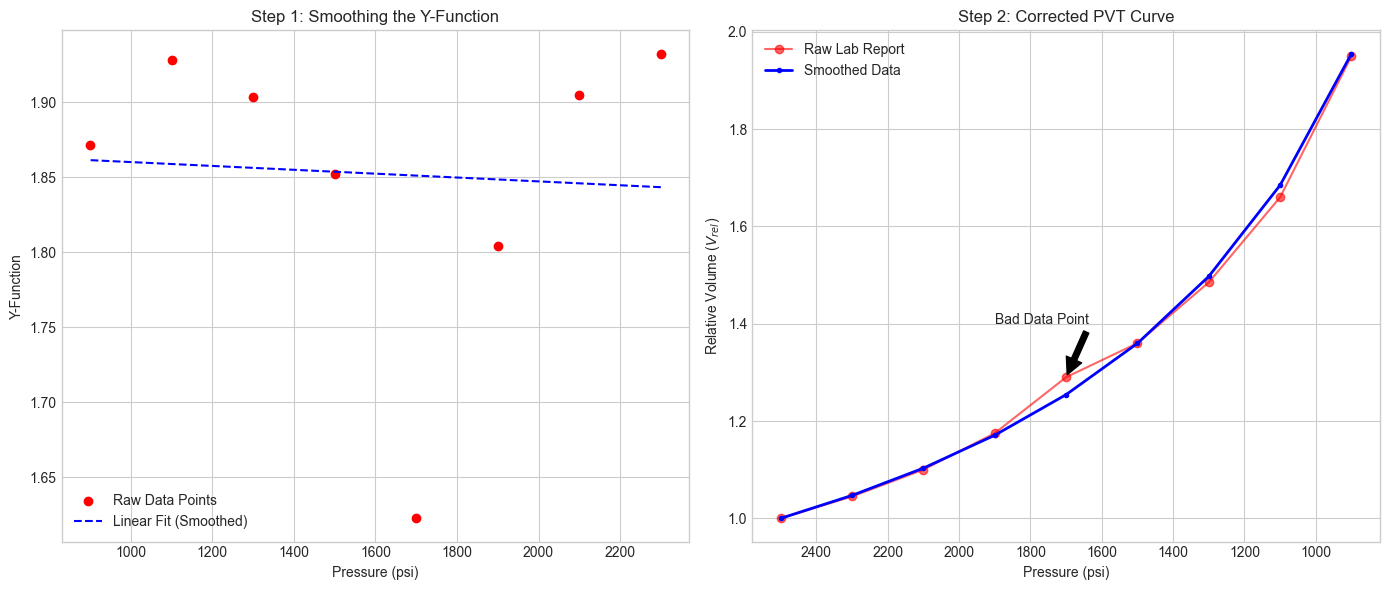

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: The Y-Function Fit
ax1.scatter(df_sub['Pressure'], df_sub['Y_func'], color='red', label='Raw Data Points')
ax1.plot(df_sub['Pressure'], df_sub['Y_smooth'], 'b--', label='Linear Fit (Smoothed)')
ax1.set_xlabel('Pressure (psi)')
ax1.set_ylabel('Y-Function')
ax1.set_title('Step 1: Smoothing the Y-Function')
ax1.legend()
ax1.grid(True)

# Plot 2: Relative Volume Correction
ax2.plot(df_final['Pressure'], df_final['V_rel_meas'], 'ro-', label='Raw Lab Report', alpha=0.6)
ax2.plot(df_final['Pressure'], df_final['V_rel_smooth'], 'b.-', label='Smoothed Data', linewidth=2)

# Highlight the error point
ax2.annotate('Bad Data Point', xy=(1700, 1.29), xytext=(1900, 1.4),
             arrowprops=dict(facecolor='black', shrink=0.05))

ax2.set_xlabel('Pressure (psi)')
ax2.set_ylabel('Relative Volume ($V_{rel}$)')
ax2.set_title('Step 2: Corrected PVT Curve')
ax2.invert_xaxis() # Reservoir engineers like high pressure on the left
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Conclusion

Using the **Y-Function smoothing technique**, we successfully:
1.  Identified a data inconsistency at 1700 psi.
2.  Generated a corrected $V_{rel}$ curve that is consistent with the Equation of State.

This "Smoothed" dataset is what should be exported to reservoir simulation software (like Eclipse, CMG, or tNavigator) to prevent convergence errors.